# Quantum Approximate Optimization Algorithm (QAOA) for Phylogenetic Trees

---

In this notebook, we are going to use Qiskit to solve the needed optimization problem to reconstruct Phylogenetic Trees. This work will be based in 2 documents, a book that describes QAOA [1], and the paper for reconstruction of Phylogenetic Trees [2].



[1] Combarro, E. F., & Gonzalez-Castillo, S. (2023). A practical guide to quantum machine learning and quantum optimisation: Hands-On Approach to Modern Quantum Algorithms. Packt Publishing.

[2] Onodera, W., Hara, N., Aoki, S., Asahi, T., & Sawamura, N. (2022). Phylogenetic tree reconstruction via graph cut presented using a quantum-inspired computer. Molecular Phylogenetics and Evolution, 178, 107636. https://doi.org/10.1016/j.ympev.2022.107636

In [1]:
import numpy as np
import dimod
from dimod import BinaryQuadraticModel, BINARY
from typing import Optional
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import re
from qaoa_functions import *
from qa_functions import TreeNode,min_cut_c,n_cut,Timer
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix
from qiskit.quantum_info import Pauli,SparsePauliOp,Statevector
from typing import Union
from colorama import Fore
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize

Firstly, we need to transform the expression of the BQM to a Ising Hamiltonian, to do this, we'll make use of D-Wave functions. After we have the Ising Hamiltonian, we'll parse the expression in the way we need it.

In [9]:
matrix = np.array( [[ 0, 92, 73, 78, 92],
                    [92,  0, 21, 49, 34],
                    [73, 21,  0, 35, 63],
                    [78, 49, 35,  0, 29],
                    [92, 34, 63, 29,  0]])

# Function to get the needed expression to create a QAOA
def prepare_exp(matrix:np.ndarray,c=0):
    r"""
    Prepares the Hamiltonian needed for the QAOA circuit
    
    Args:
        `matrix` (np.ndarray): Numpy array containing the simmetric (or lower triangular matrix) that defines the problem.
        `c` (int): Number of non-zero variables.
        `tags` (list): Defines the name of the variables. **MUST BE AN INT LIST**
        
    Returns:
        The expression as a string.        
    """
    
    
    alpha = matrix.shape[0]*100
    h, J, _ = min_cut_c(matrix,c=c,alpha=alpha).to_ising()
    # print(f'Linar coeffs: {h}')
    # print(f'Quadratic terms: {J}')
    exp = ""

    for term in J:
        exp+="+"+str(J[term])+"Z"+str(term[0])+"Z"+str(term[1])

    for term in h:
        if h[term]!=0:
            exp+="+"+str(h[term])+"Z"+str(term)
            
    return exp 

def combine_inverse_keys(original_dict):
    """
    Combines the reciprocal solutions as only one solution
    """
    new_dict = {}
    
    for key, value in original_dict.items():
        # Compute the inverse key
        inverse_key = ''.join('1' if bit == '0' else '0' for bit in key)
        
        # Sort the pair to ensure consistent representation
        combined_key = min(key, inverse_key)
        
        # Add value to the combined key
        if combined_key in new_dict:
            new_dict[combined_key] += value
        else:
            new_dict[combined_key] = value
    
    return new_dict

def get_bes_sol(qc:QuantumCircuit)->dict:
    """   Runs the quantic circuit simulation and returns the value with more counts   """
    sim = AerSimulator()

    # Transpile the circuit for the simulator or real QPU
    qc.measure_all()
    qc = transpile(qc,sim)

    # Run the circuit and collect results
    sampler = SamplerV2()
    job = sampler.run([qc],shots=2048)
    job_result = job.result()
    counts=job_result[0].data.meas.get_counts()
    n_counts = combine_inverse_keys(counts)
    best = max(n_counts,key=n_counts.get)
    return best

exp = prepare_exp(matrix,c=0)
print(exp)

+204.0Z0Z1+239.5Z2Z1+213.5Z2Z0+225.5Z3Z1+211.0Z3Z0+232.5Z3Z2+233.0Z4Z1+204.0Z4Z0+218.5Z4Z2+235.5Z4Z3+1250.0Z1+1250.0Z0+1250.0Z2+1250.0Z3+1250.0Z4


Using the `phylo_tree` function from [qa_functions.py](qa_functions.py) as a base, we can use QAOA instead of the QA that we used before. We also need to change the way the solution and the tags will be used.

In [106]:
def qaoa_phylo_tree(matrix:np.ndarray,tags=[],**kwargs):
    r"""
    Recursive function that uses QAOA to create the Phylogenetic tree using Ncut
    
    Args:
        `matrix`: The matrix defining the graph.
        `tags`: Tags defining the names of the nodes, used for recursivity. **MUST BE AN INT LIST**
    Returns:
        The `TreeNode` containing the full tree. 
    """
    ncuts = []
    n_graph_0 = []
    n_graph_1 = []
    
    if not tags:
        sub_mat = matrix
        tags = list(range(matrix.shape[0]))
    else:
        sub_mat = matrix[np.ix_(tags, tags)]
        
    rows = sub_mat.shape[0]
    
    var = int(np.floor(rows/2.0))+1

    # Run min_cut for each configuration
    for i in range(1,var):
        print(f'Corte con {i}')
        if 'timer' in kwargs:
            start = time.time_ns()/1000000
        # Prepare the expression and run the QAOA    
        problem = prepare_exp(sub_mat,c=i)
        qaoa = QAOA(problem,rows)
        qaoa.get_opt_circ()
        result = get_bes_sol(qaoa.qc)
        
        ###### TODO: FALTA CAMBIAR TODO LO DE DESPUES
        
        # Time measurement
        if 'timer' in kwargs:
            end = time.time_ns()/1000000
            kwargs['timer'].update(end-start)
            
        n_graph_0.append([tags[j] for j in range(len(result)) if result[j]=='0'])
        n_graph_1.append([tags[j] for j in range(len(result)) if result[j]=='1'])        
        print(f'\tLa division es: {n_graph_0[i-1]} | {n_graph_1[i-1]}')
        
        if not n_graph_0[i-1] or not n_graph_1[i-1]:
            n_graph_0.pop()
            n_graph_1.pop()
        else:
            ncuts.append(n_cut(qaoa.min,n_graph_0[i-1],n_graph_1[i-1],matrix))
        
    
    # Get the cuts created by the minimum ncut value
    index = np.argmin(ncuts)
    print(f'Se selecciona la separacion: {n_graph_0[index]} | {n_graph_1[index]}')
    
    node = TreeNode(tags)
    
    # Recursivity in the first graph
    if len(n_graph_0[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(qaoa_phylo_tree(matrix,tags=n_graph_0[index],timer=kwargs['timer']))
        else:
            node.children.append(qaoa_phylo_tree(matrix,tags=n_graph_0[index]))
    else:
        leaf = TreeNode(n_graph_0[index])
        if len(n_graph_0[index]) == 2:
            leaf.children.append(TreeNode([n_graph_0[index][0]]))
            leaf.children.append(TreeNode([n_graph_0[index][1]]))
        node.children.append(leaf)
        
    # Recursivity in the first graph
    if len(n_graph_1[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(qaoa_phylo_tree(matrix,tags=n_graph_1[index],timer=kwargs['timer']))
        else:
            node.children.append(qaoa_phylo_tree(matrix,tags=n_graph_1[index]))
    else:
        leaf = TreeNode(n_graph_1[index])
        if len(n_graph_1[index]) == 2:
            leaf.children.append(TreeNode([n_graph_1[index][0]]))
            leaf.children.append(TreeNode([n_graph_1[index][1]]))
        node.children.append(leaf)
    
    return node

Corte con 1
	La division es: [0, 2, 3] | [1, 4]
Corte con 2
	La division es: [0, 1, 2] | [3, 4]
Se selecciona la separacion: [0, 1, 2] | [3, 4]
Corte con 1
	La division es: [0, 1] | [2]
Se selecciona la separacion: [0, 1] | [2]
El tiempo utilizado es: 4422.162109375


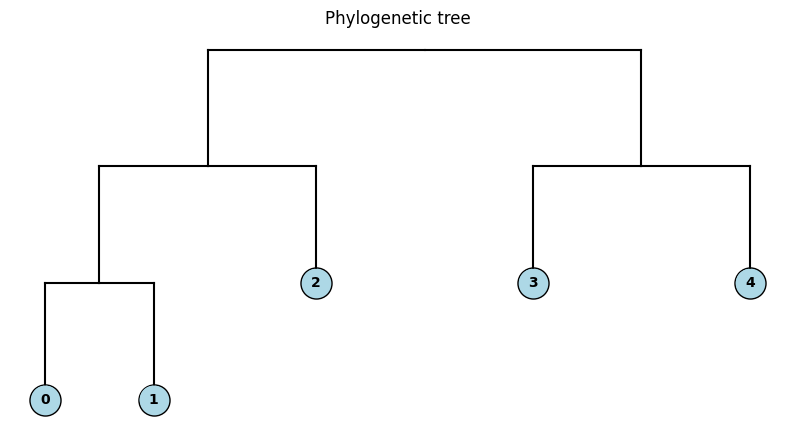

In [107]:
timer = Timer(0.0)
matrix = np.array( [[ 0, 92, 73, 78, 92],
                    [92,  0, 21, 49, 34],
                    [73, 21,  0, 35, 63],
                    [78, 49, 35,  0, 29],
                    [92, 34, 63, 29,  0]])
tree = qaoa_phylo_tree(matrix,timer=timer)
print(f'El tiempo utilizado es: {timer}')
tree.display_tree()

The QAOA does whatever it likes and it has a really high variability. We can explore this in especific examples, for example let's take the first iteration of `qaoa_phylo_tree` ($c=1$). Using this setup, we should get a solution with only one of the variables as 1.

[0.98562182 1.04647823]
10100 -518.9658203125


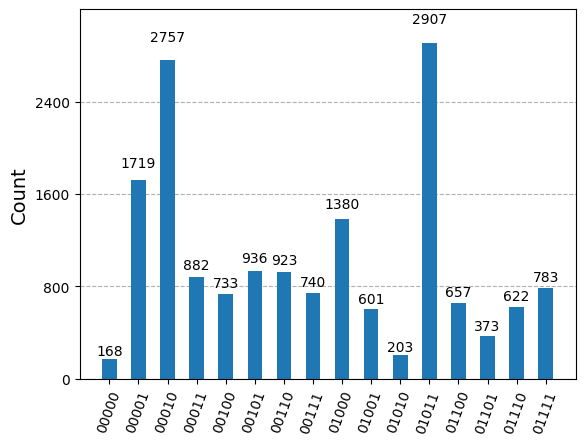

In [56]:
problem = prepare_exp(matrix,c=1)
size = max([int(x) for x in re.findall(r'Z([0-9]+)',problem)])+1
qaoa = QAOA(problem,size,x0=[0.0,0.0],method='COBYLA')
qaoa.get_opt_circ()
print(qaoa.param)
sim = AerSimulator()

# Transpile the circuit for the simulator or real QPU
qaoa.qc.measure_all()
qc = transpile(qaoa.qc,sim)

# Run the circuit and collect results
sampler = SamplerV2()
job = sampler.run([qaoa.qc],shots=16384)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()
print(max(counts,key=counts.get),qaoa.min)
comb_counts = combine_inverse_keys(counts)
plot_histogram(comb_counts)

In [101]:
params = []
minim = []

act_min = np.inf
j=0
problem = prepare_exp(matrix,c=2)
size = max([int(x) for x in re.findall(r'Z([0-9]+)',problem)])+1

for i in range(100):
    initial_guess = np.random.random(2)
    qaoa = QAOA(problem,size,x0=initial_guess)
    qaoa.get_opt_circ()
    params.append(qaoa.param)
    minim.append(qaoa.min)
    if qaoa.min< act_min:
        act_min = qaoa.min
        arg = qaoa.param
        j=i
        print(f'El nuevo minimo es {act_min} con {arg}')
    
print(f'El minimo es: {act_min}, y se da con los parametros: {arg}')
print(f'Se da el minimo en la iteracion {j}')

El nuevo minimo es -186.3330078125 con [0.72209782 1.16425449]
El nuevo minimo es -277.8515625 con [ 1.7411203  -0.85833115]
El nuevo minimo es -294.859375 con [0.66851062 0.79199686]
El nuevo minimo es -303.0224609375 con [ 0.66228109 -0.36987423]
El nuevo minimo es -369.9951171875 con [ 0.6611563 -0.9539887]
El nuevo minimo es -386.826171875 con [0.66122225 1.90830494]
El nuevo minimo es -393.595703125 con [1.90016606 2.17006518]
El nuevo minimo es -481.5419921875 con [1.58732765 2.29519905]
El nuevo minimo es -493.2744140625 con [1.90751274 0.73466975]
El minimo es: -493.2744140625, y se da con los parametros: [1.90751274 0.73466975]
Se da el minimo en la iteracion 53


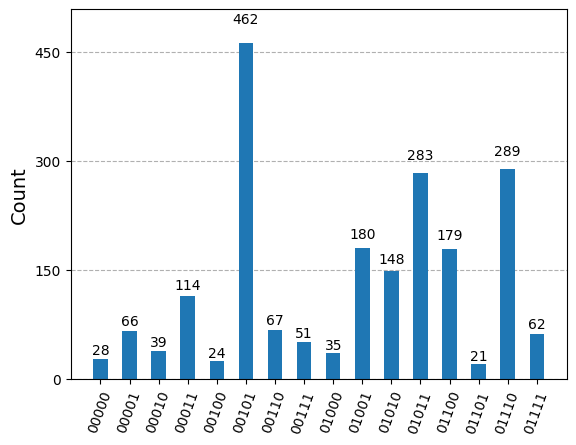

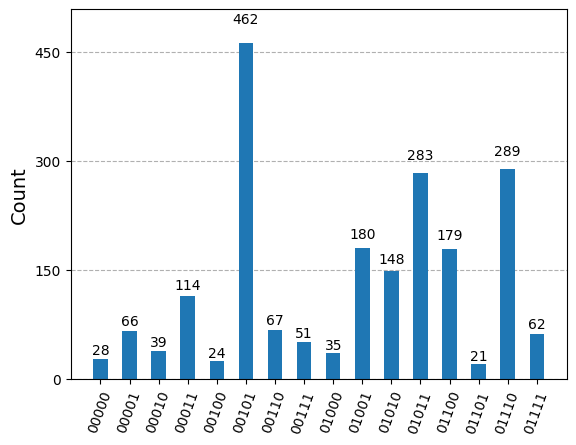

In [102]:
qc = create_ansatz(problem,size,1,[arg[0]], [arg[1]])
sim = AerSimulator()

# Transpile the circuit for the simulator or real QPU
qc.measure_all()
qc = transpile(qc,sim)

# Run the circuit and collect results
sampler = SamplerV2()
job = sampler.run([qc],shots=2048)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()
n_counts = combine_inverse_keys(counts)
plot_histogram(n_counts)

In [81]:
qc = create_ansatz(problem,size,1,[arg[0]],[arg[1]])

# Define the grid for plotting
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
Z = {}

for i in x:
    for j in y:
        qc = create_ansatz(problem,size,1,[i],[j])
        Z[(i,j)] = get_energy(qc,problem)

In [86]:
min(Z,key=Z.get)
Z[(np.float64(-0.02020202020202011), np.float64(-0.5858585858585856))]

np.float64(-997.326171875)

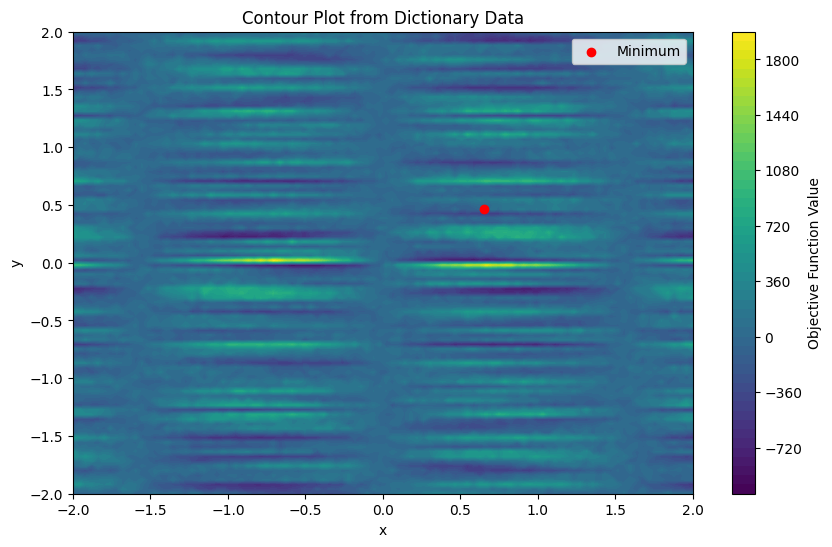

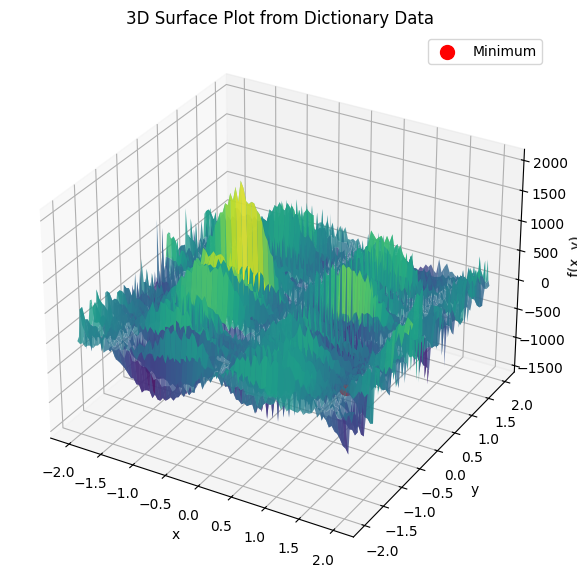

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline
coords = np.array(list(Z.keys()))
x = coords[:, 0]
y = coords[:, 1]
z = np.array(list(Z.values()))

# Create a grid for plotting
x_unique = np.unique(x)
y_unique = np.unique(y)
X, Y = np.meshgrid(x_unique, y_unique)

# Reshape z values into the grid
Z_grid = np.zeros_like(X, dtype=float)
for i in range(len(x)):
    xi, yi = x[i], y[i]
    Z_grid[np.where(x_unique == xi), np.where(y_unique == yi)] = z[i]

# Plot the contour
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, Z_grid, levels=50, cmap='viridis')
plt.colorbar(contour, label='Objective Function Value')
plt.scatter(0.65444527, 0.46155226, color='red', label='Minimum', zorder=5)  # Example minimum
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour Plot from Dictionary Data')
plt.show()

%matplotlib inline
# Optional: 3D Surface Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_grid, cmap='viridis', alpha=0.8)
ax.scatter(0.65444527,0.46155226, -1369.1376953125, color='red', s=100, label='Minimum')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('3D Surface Plot from Dictionary Data')
plt.legend()
plt.show()

## Problems

Using this approach we've come to a problem. Due to the nature of the landscape, finding a good minimum may be difficult, so the optimizer stops in suboptimal parameters getting mostly wrong solutions. To fix this, we can try other optimizers that get the minimum parameters often. If using gradient descent doesn't work we can try other methods like differential evolution, or other ones.

In [112]:
from scipy.optimize import differential_evolution
problem = prepare_exp(matrix,c=1)
size = max([int(x) for x in re.findall(r'Z([0-9]+)',problem)])+1
qaoa = QAOA(problem,size)

bounds = [(-2, 2), (-2, 2)]

result = differential_evolution(qaoa.objective,bounds)
print(result.x)
print(result.fun)

KeyboardInterrupt: 